## Code Description:

1. **Configuration Import (`config`)**: This line imports a `config` module, likely containing custom settings or credentials used later in the project (e.g., database connection strings).

2. **Pandas Library (`pd`)**: The `pandas` library is imported for data manipulation. Pandas is a powerful tool for working with tabular data, essential for filtering, cleaning, and processing the BDOT10k data.

3. **Matplotlib (`plt`)**: The `matplotlib.pyplot` library is imported for data visualization. This will be useful for generating plots and graphs, such as visualizing the solar irradiance and slope parameters used in the analysis.

4. **FixedLocator**: This specific import from `matplotlib.pyplot` is used to fix the location of ticks in plots, which is likely to come in handy when visualizing geographically linked data.

5. **SQLAlchemy (`create_engine`)**: The `create_engine` function from SQLAlchemy is imported, hinting that a database connection (likely PostGIS or other spatial databases) will be established. This allows seamless integration between the database and Python for querying and managing geospatial data.

6. **Precision Setting**: The pandas display precision is set to 2 decimal places, ensuring that all floating-point data (e.g., slope angles or solar irradiance) are consistently displayed with two digits of precision in any DataFrame outputs.

---

This is an introductory setup cell that establishes the necessary libraries and configurations for data manipulation, visualization, and database integration in the subsequent analysis. Let me know if you need any further adjustments!


In [14]:
# Import necessary libraries and modules
import config
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import FixedLocator
from sqlalchemy import create_engine

# Set display option for pandas DataFrames to limit float precision to 2 decimal places
pd.set_option("display.precision", 2)

# Database Connection Setup

1. **Configuration Data:**
   - The **`mysql`** dictionary is imported from the **`config`** module, which stores database credentials such as the username, password, host, port, and database name.

2. **Connection String:**
   - A PostgreSQL connection string is constructed using the credentials from the **`mysql`** dictionary.
   - The connection string follows the format: 
     ```
     postgresql://<user>:<password>@<host>:<port>/<dbname>
     ```

3. **Database Engine:**
   - The **`create_engine()`** function from SQLAlchemy is used to create a connection engine, which allows communication with the PostgreSQL database. This will enable efficient querying and manipulation of data stored in the database.

4. **Connection:**
   - The **`conn`** object is created by calling **`engine.connect()`**, which establishes an active connection to the database. This connection can now be used to perform SQL queries and retrieve the required data for analysis.

This step is critical as it sets up the database connection, allowing access to the data needed for analyzing potential wind and solar farm locations.


In [15]:
# Import database configuration
mysql = config.mysql

# Construct PostgreSQL connection string
connection_string = (
    f"postgresql://{mysql['user']}:{mysql['password']}@"
    f"{mysql['host']}:{mysql['port']}/{mysql['dbname']}"
)

# Create database engine
engine = create_engine(connection_string)

## Defining Polish Provinces

This section defines a list of Polish provinces that will be used for data filtering or selection purposes during the analysis. Each province represents a geographical region in Poland, where the potential locations for wind and solar farms will be evaluated.

The list includes the names of all 16 provinces (województwa) in Poland:

- Dolnośląskie
- Kujawsko-pomorskie
- Lubelskie
- Lubuskie
- Łódzkie
- Małopolskie
- Mazowieckie
- Opolskie
- Podkarpackie
- Podlaskie
- Pomorskie
- Śląskie
- Świętokrzyskie
- Warmińsko-mazurskie
- Wielkopolskie
- Zachodniopomorskie

This list will likely be used later in the analysis to subset data or run analyses for specific regions.


In [16]:
# Define a list of Polish provinces (województwa)
provinces = [
    "dolnoslaskie",
    "kujawsko_pomorskie",
    "lubelskie",
    "lubuskie",
    "lodzkie",
    "malopolskie",
    "mazowieckie",
    "opolskie",
    "podkarpackie",
    "podlaskie",
    "pomorskie",
    "slaskie",
    "swietokrzyskie",
    "warminsko_mazurskie",
    "wielkopolskie",
    "zachodniopomorskie"
]


## Renewable Energy Potential by Province

This section calculates the total potential area available for solar and wind energy production across Polish provinces. It retrieves data from two types of tables:

- **Solar photovoltaic potential area**: Calculated from `solar_radiation_photovoltaic_area_{province}` tables.
- **Wind energy potential area**: Calculated from `wind_speed_area_{province}` tables.

The data for each province is fetched from a PostgreSQL database, and the total area for both solar and wind potential is computed. The result is presented in square kilometers (km²) for easier interpretation.

### Steps:

1. **Data Initialization**:
    - Two dictionaries, `solar_area_append_total` and `wind_area_append_total`, are created to store the results for each province.

2. **Data Extraction**:
    - For each province, the corresponding table names for solar and wind energy data are generated.
    - SQL queries are constructed to sum up the available area (`SUM(area)`) for both solar and wind in each province.

3. **Data Validation**:
    - After fetching data using `pd.read_sql`, it is checked whether valid data was retrieved. If no data is found or the area is `None`, the area is set to 0.

4. **Unit Conversion**:
    - The area is converted from square meters (m²) to square kilometers (km²) using a factor of `1e-6`, and the result is rounded to 2 decimal places.

5. **Data Storage**:
    - The calculated values are appended to the dictionaries, which are later converted into Pandas DataFrames for both solar and wind areas.

The resulting DataFrames, `df_solar` and `df_wind`, hold the calculated total potential area for renewable energy in each province.


In [34]:
# Initialize dictionaries to store total renewable areas for solar and wind by province
solar_area_append_total = {'Province': [], 'solar_area': []}
wind_area_append_total = {'Province': [], 'wind_area': []}

# Establish persistent connection to the database
conn = engine.connect()

# Import data from the database for each province
for province in provinces:
    
    # Define table names for solar and wind data
    table_name_solar = f"solar_radiation_photovoltaic_area_{province}"
    table_name_wind = f"wind_speed_area_{province}"
  
    # SQL queries to get the total area for solar and wind energy
    query_solar = (f"SELECT SUM(area) as solar_total_area FROM {table_name_solar}")
    query_wind = (f"SELECT SUM(area) as wind_total_area FROM {table_name_wind}")
    
    # Execute queries and store results in pandas DataFrames
    solar_result = pd.read_sql(query_solar, conn)
    wind_result = pd.read_sql(query_wind, conn)
    
    # Check if valid data is retrieved, set area to 0 if data is missing
    solar_area = solar_result['solar_total_area'][0] if not solar_result.empty and solar_result['solar_total_area'][0] is not None else 0
    wind_area = wind_result['wind_total_area'][0] if not wind_result.empty and wind_result['wind_total_area'][0] is not None else 0
    
    # Append results to the respective lists, converting m² to km²
    solar_area_append_total['Province'].append(province)
    solar_area_append_total['solar_area'].append(round(solar_area * 1e-6, 2))
    
    wind_area_append_total['Province'].append(province)
    wind_area_append_total['wind_area'].append(round(wind_area * 1e-6, 2))


# Convert the dictionaries to pandas DataFrames
df_solar = pd.DataFrame(solar_area_append_total)
df_wind = pd.DataFrame(wind_area_append_total)

# Display the solar potential area DataFrame
df_solar

,Province,solar_area
0,dolnoslaskie,480.64
1,kujawsko_pomorskie,262.50
2,lubelskie,594.29
3,lubuskie,326.41
4,lodzkie,485.20
5,malopolskie,441.87
6,mazowieckie,1344.64
7,opolskie,90.20
8,podkarpackie,568.48
9,podlaskie,962.12


## Visualization of Renewable Energy Potential

The bar plot below illustrates the total area available for solar and wind energy generation for each province in Poland. The blue bars represent the potential area for solar energy, while the green bars represent the potential area for wind energy. The data is presented in square kilometers (km²).

This visualization provides an easy comparison of the renewable energy potential across different regions, showing how provinces differ in their capacity for both solar and wind energy development.

- **X-axis**: Names of the provinces.
- **Y-axis**: Total area available for renewable energy (km²).
- **Bars**:
    - **Blue**: Solar energy potential.
    - **Green**: Wind energy potential.

The plot highlights the variation in renewable resource availability, which is crucial for planning large-scale energy projects.


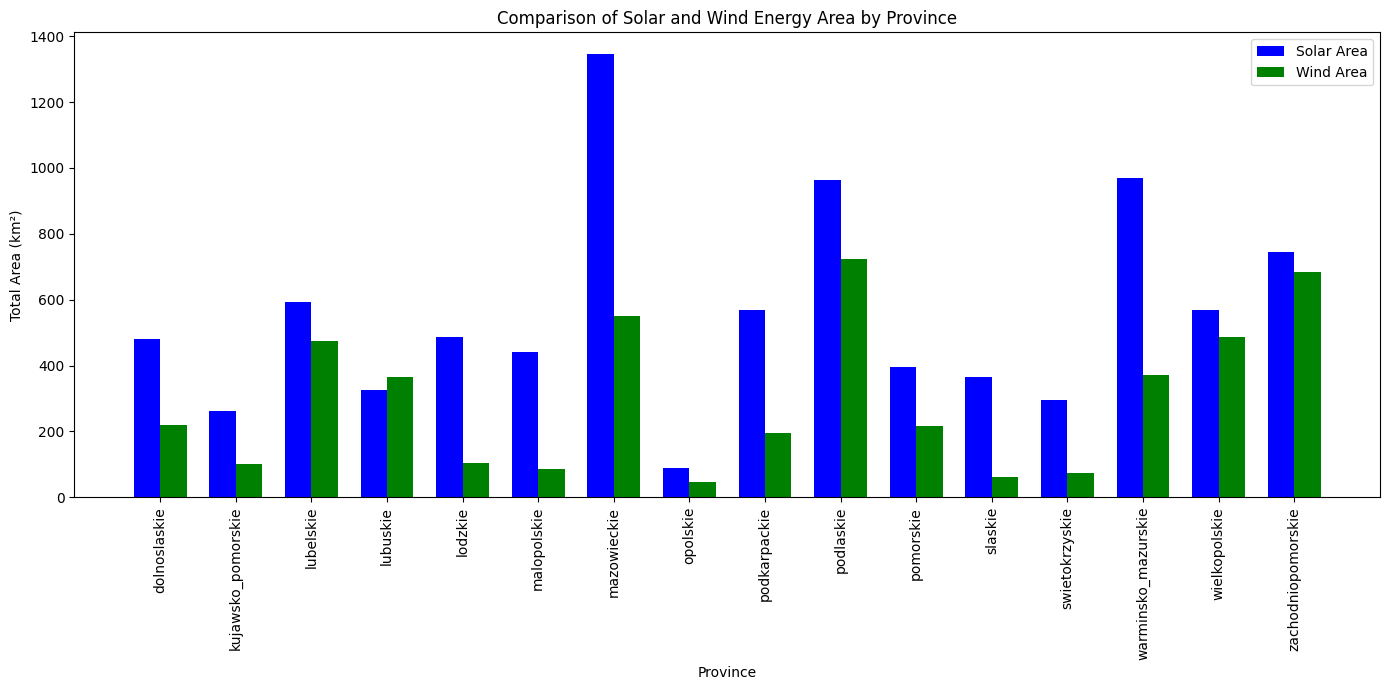

In [18]:
# Create a bar plot to compare solar and wind energy areas by province
plt.figure(figsize=(14, 7))
width = 0.35  # Width of the bars

# Position of the bars for each province
ind = range(len(df_solar['Province']))

# Create bars for solar and wind energy areas
plt.bar(ind, df_solar['solar_area'], width=width, label='Solar Area', color='blue')
plt.bar([i + width for i in ind], df_wind['wind_area'], width=width, label='Wind Area', color='green')

# Add labels, title, and format the x-ticks
plt.xlabel('Province')
plt.ylabel('Total Area (km²)')
plt.title('Comparison of Solar and Wind Energy Area by Province')
plt.xticks([i + width / 2 for i in ind], df_solar['Province'], rotation=90)

# Add legend and display the plot
plt.legend()
plt.tight_layout()
plt.show()

Photovoltaic Panel Parameters and Effective Area Calculation
In this section, we calculate the effective area available for photovoltaic (PV) panel installations. Key factors include the size and efficiency of the panels, as well as adjustments to account for space required for equipment and maintenance access.

Key Parameters:
Panel Size: Each panel has a height of 1.016 m and a width of 1.686 m, giving a surface area of approximately 1.71 m².
Power Output: The standard power output of a panel is 0.350 kW, leading to a power output of around 0.205 kW per square meter (kW/m²).
Efficiency: The panel efficiency is calculated under standard conditions of 25°C and 1000 W/m², with an efficiency close to 20%.
Effective Area: We cannot use the entire area for panels, as some space (20%) must be allocated for equipment and maintenance access, meaning only 80% of the area is available for PV panels.
The code below calculates the effective solar panel area in each province, taking into account these factors.

In [19]:
# Photovoltaic standard panel parameters
height_panel = 1.016  # Height of a single panel in meters
width_panel = 1.686  # Width of a single panel in meters
power_output = 0.350  # Power output per panel in kW
power_output_m2 = power_output / (height_panel * width_panel)  # Power output per m²

# Efficiency of the panel under standard conditions (~20% efficiency)
efficiency = (power_output / (height_panel * width_panel * 1))

# Parameters for effective solar area (80% area used for panels, 20% for equipment and access)
solar_maintenance_access = 0.2  # 20% area reserved for equipment and access
effective_solar_panel_area = 1 - solar_maintenance_access  # 80% area for PV panels

# Calculate the effective solar area for each province
df_solar['solar_effective_area'] = df_solar['solar_area'] * effective_solar_panel_area

# Display the DataFrame with the new column
df_solar

,Province,solar_area,solar_effective_area
0,dolnoslaskie,480.64,384.51
1,kujawsko_pomorskie,262.50,210.00
2,lubelskie,594.29,475.43
3,lubuskie,326.41,261.13
4,lodzkie,485.20,388.16
5,malopolskie,441.87,353.50
6,mazowieckie,1344.64,1075.71
7,opolskie,90.20,72.16
8,podkarpackie,568.48,454.78
9,podlaskie,962.12,769.70


Solar Radiation Calculation by Province and Month
This section calculates the total solar energy potential for each province based on monthly solar radiation data. The calculation considers the available photovoltaic area, panel efficiency, and monthly sunlight duration. The final data is merged into the df_solar DataFrame.

Key Steps:
Months Dictionary: A dictionary with the number of days in each month is defined.
Query Construction: For each province and month, a SQL query is used to sum up the total area available for photovoltaic installations, multiply it by monthly solar radiation, adjust for panel efficiency, and account for the 80% effective area utilization.
Energy Calculation: The resulting energy is converted from kW to MW for easier interpretation.
Data Merging: The calculated solar radiation data is merged with the existing df_solar DataFrame.


In [36]:
# Dictionary containing months and their respective number of days
months = {
    "january": 31,
    "february": 28,
    "march": 31,
    "april": 30,
    "may": 31,
    "june": 30,
    "july": 31,
    "august": 31,
    "september": 30,
    "october": 31,
    "november": 30,
    "december": 31
}

# DataFrame to store solar radiation by province and month
solar_radiation = pd.DataFrame(index=provinces, columns=months.keys())

# Loop through each province and month to calculate solar radiation
for province in provinces:
    for month in months:
        table_name_solar = f"solar_radiation_photovoltaic_area_{province}"
        
        # SQL query to calculate total solar energy in the month (accounting for area, radiation, efficiency)
        query = (f"SELECT SUM(area * {months[month]} * {effective_solar_panel_area} * {efficiency}) "
                 f"AS total FROM {table_name_solar}")
        
        # Execute the query and store result in DataFrame
        result_df = pd.read_sql(query, conn)
        monthly_solar_energy = result_df.iloc[0]['total'] if not result_df.empty else 0
        
        # Convert from kW to MW and store in the DataFrame
        solar_radiation.at[province, month] = round(monthly_solar_energy * 1e-3, 2)

# Reset index and rename columns
solar_radiation.reset_index(inplace=True)
solar_radiation.rename(columns={'index': 'Province'}, inplace=True)

# Merge the solar radiation data with the df_solar DataFrame
df_solar = df_solar.merge(solar_radiation, left_on='Province', right_on='Province')

# Functional Assumptions for Wind Energy

- **Turbines per km²**: We assume 3 wind turbines for every square kilometer of wind-available land.
- **Wind Turbine Model**: The parameters for the Vestas V100 turbine are as follows:
    - Minimum wind speed for operation: **3 m/s**
    - Maximum wind speed for operation: **22 m/s**
    - Maximum energy generation: **2 MW** (at 22 m/s)


In [38]:
# Functional assumption: 3 wind turbines per km²
turbine_number_for_area = 3
df_wind['turbines_number'] = df_wind['wind_area'] * turbine_number_for_area
df_wind['turbines_number'] = df_wind['turbines_number'].astype(int)

# Parameters for wind turbine Vestas V100
# Minimum wind speed [m/s]
minimum_wind_speed = 3

# Maximum wind speed [m/s]
maximum_wind_speed = 22

# Energy generated per hour at 22 m/s wind speed [MW]
maximum_power_generate = 2

df_wind


,Province,wind_area,turbines_number
0,dolnoslaskie,220.40,661
1,kujawsko_pomorskie,100.90,302
2,lubelskie,473.40,1420
3,lubuskie,366.51,1099
4,lodzkie,104.86,314
5,malopolskie,86.31,258
6,mazowieckie,551.29,1653
7,opolskie,47.03,141
8,podkarpackie,195.24,585
9,podlaskie,722.85,2168


# Wind Energy Calculation by Province

For each province, we calculate the wind energy generated per month using the following assumptions:

- **Wind Speed Thresholds**:
    - **Minimum Wind Speed**: 3 m/s (below this, no energy is generated)
    - **Maximum Wind Speed**: 22 m/s (maximum energy output at this speed)

- **Energy Generation Formula**:
    - Energy generated is proportional to the wind speed up to 22 m/s.
    - For wind speeds above 3 m/s, the energy generated per hour is calculated based on the wind speed ratio compared to the maximum wind speed.

For each month, the energy generated is calculated in MW for every province.


In [39]:
# Create a DataFrame for wind energy
wind_energy = pd.DataFrame(index=provinces, columns=months.keys())

# Loop through each province and month to calculate wind energy
for province in provinces:
    for month, days in months.items():
        table_name_wind = f"wind_speed_area_{province}"
        
        # Select data in tables and calculate energy generated for 1 month in MW
        query = (f"SELECT SUM(CASE "
                 f"WHEN {month} > {minimum_wind_speed} THEN ((({month} * 24 * {days}) / {maximum_wind_speed}) * {maximum_power_generate}) "
                 f"ELSE 0 "
                 f"END) as total "
                 f"FROM {table_name_wind}")

        # Fetch result into pandas
        result_df = pd.read_sql(query, conn)
        monthly_wind_speed = result_df.iloc[0]['total'] if not result_df.empty else 0
        
        # Round the result and assign it to the DataFrame
        monthly_wind_speed = round(monthly_wind_speed, 2)
        wind_energy.at[province, month] = monthly_wind_speed
        
# Rename index for merging
wind_energy.reset_index(inplace=True)
wind_energy.rename(columns={'index': 'Province'}, inplace=True)

# Merge wind energy data with the existing df_wind DataFrame
df_wind = df_wind.merge(wind_energy, left_on='Province', right_on='Province')

df_wind

,Province,wind_area,turbines_number,january,february,march,april,may,june,july,august,september,october,november,december
0,dolnoslaskie,220.40,661,447120,396744,423090,120640,0,0,0,0,11440,256770,325520,445230
1,kujawsko_pomorskie,100.90,302,115072,97600,108000,104000,65340,60840,12960,0,97240,108000,104000,108000
2,lubelskie,473.40,1420,534060,482632,534060,162760,18090,0,0,0,41340,477630,514280,534060
3,lubuskie,366.51,1099,423630,382836,423630,11180,0,0,0,0,1300,394470,407940,423630
4,lodzkie,104.86,314,214228,170800,189000,181480,96390,0,0,0,164840,189000,182000,189816
5,malopolskie,86.31,258,103950,93940,103950,1560,0,0,0,0,0,31860,43160,68580
6,mazowieckie,551.29,1653,741136,663192,733860,232960,68040,4420,0,0,182000,693630,706680,733860
7,opolskie,47.03,141,126900,114680,117180,49140,5670,0,0,0,14300,83160,96200,126900
8,podkarpackie,195.24,585,369900,334280,353160,30420,0,0,0,0,0,273240,355940,383670
9,podlaskie,722.85,2168,344790,311588,344790,147680,8640,0,0,0,109720,344790,332020,344790


# Solar Radiation Analysis by Province

For each province, we calculate the solar radiation energy production and the estimated building costs for photovoltaic panels. We perform the following operations:

- **Area and Distances**:
    - Area in km²
    - Line distance and road distance in km

- **Solar Energy Production**:
    - Total and monthly energy production (in MWh) calculated based on the effective solar panel area and panel efficiency.

- **Construction Cost**:
    - The construction cost (in millions of PLN) is calculated based on the energy production, using a tiered cost approach.

- **Solar Radiation Difference**:
    - The difference in solar radiation values between the maximum monthly radiation and the total sum of all months.

Each province is processed, and the resulting DataFrame is stored in a dictionary for easy access.


In [40]:
# Initialize a dictionary to store the solar radiation data for each province
solar_radiation_photovoltaic_area_by_each_province = {}

# Loop through each province to calculate solar radiation and other metrics
for province in provinces:
    
    # Define the table name for the current province
    table_name = f"solar_radiation_photovoltaic_area_{province}"
    
    # Define the sum of monthly columns for solar radiation difference calculation
    sum_columns = ' + '.join(months)
    
    # Define the SQL query for fetching solar radiation and energy production data
    query = (
        f"SELECT "
        f"id, "
        f"area * 1e-6 AS area_km2, "
        f"line_dista * 1e-3 AS line_distance_km, "
        f"road_dista * 1e-3 AS road_distance_km, "
        f"area * {effective_solar_panel_area} * {efficiency} * 1e-3 AS solar_energy_production_mwh, "
        
        # Monthly energy production
        f"area * {effective_solar_panel_area} * {efficiency} * january * 1e-3 AS january_solar_energy_production_mwh, "
        f"area * {effective_solar_panel_area} * {efficiency} * february * 1e-3 AS february_solar_energy_production_mwh, "
        f"area * {effective_solar_panel_area} * {efficiency} * march * 1e-3 AS march_solar_energy_production_mwh, "
        f"area * {effective_solar_panel_area} * {efficiency} * april * 1e-3 AS april_solar_energy_production_mwh, "
        f"area * {effective_solar_panel_area} * {efficiency} * may * 1e-3 AS may_solar_energy_production_mwh, "
        f"area * {effective_solar_panel_area} * {efficiency} * june * 1e-3 AS june_solar_energy_production_mwh, "
        f"area * {effective_solar_panel_area} * {efficiency} * july * 1e-3 AS july_solar_energy_production_mwh, "
        f"area * {effective_solar_panel_area} * {efficiency} * august * 1e-3 AS august_solar_energy_production_mwh, "
        f"area * {effective_solar_panel_area} * {efficiency} * september * 1e-3 AS september_solar_energy_production_mwh, "
        f"area * {effective_solar_panel_area} * {efficiency} * october * 1e-3 AS october_solar_energy_production_mwh, "
        f"area * {effective_solar_panel_area} * {efficiency} * november * 1e-3 AS november_solar_energy_production_mwh, "
        f"area * {effective_solar_panel_area} * {efficiency} * december * 1e-3 AS december_solar_energy_production_mwh, "
        
        # Building cost calculation
        f"CASE "
        f"    WHEN area * {effective_solar_panel_area} * {efficiency} * 1e-3 < 0.5 THEN 3.51 * area * {effective_solar_panel_area} * {efficiency} * 1e-3 "
        f"    WHEN area * {effective_solar_panel_area} * {efficiency} * 1e-3 <= 1 THEN 2.63 * area * {effective_solar_panel_area} * {efficiency} * 1e-3 "
        f"    WHEN area * {effective_solar_panel_area} * {efficiency} * 1e-3 > 1 THEN 2.05 * area * {effective_solar_panel_area} * {efficiency} * 1e-3 "
        f"    ELSE 0 "
        f"END AS building_cost_mln_zl, "
        
        # Solar radiation difference
        f"((SELECT MAX(value) FROM (SELECT {sum_columns} AS value FROM {table_name}) subquery) - ({sum_columns})) AS solar_radiation_difference_kw "
        
        f"FROM {table_name}"
    )
    
    # Execute the SQL query and load the result into a pandas DataFrame
    result_df = pd.read_sql(query, conn)
    
    # Copy the result DataFrame for the current province
    solar_radiation_photovoltaic_area_by_each_province[province] = result_df.copy()
    
    # Calculate the annual energy production and add it as a new column
    solar_radiation_photovoltaic_area_by_each_province[province]['energy_production_by_year_mwh'] = \
        solar_radiation_photovoltaic_area_by_each_province[province].loc[:, 'january_solar_energy_production_mwh':'december_solar_energy_production_mwh'].sum(axis=1)

In [41]:
solar_radiation_photovoltaic_area_by_each_province['podlaskie']


,id,area_km2,line_distance_km,road_distance_km,solar_energy_production_mwh,january_solar_energy_production_mwh,february_solar_energy_production_mwh,march_solar_energy_production_mwh,april_solar_energy_production_mwh,may_solar_energy_production_mwh,june_solar_energy_production_mwh,july_solar_energy_production_mwh,august_solar_energy_production_mwh,september_solar_energy_production_mwh,october_solar_energy_production_mwh,november_solar_energy_production_mwh,december_solar_energy_production_mwh,building_cost_mln_zl,solar_radiation_difference_kw,energy_production_by_year_mwh
0,2.0,0.08,4.39e-01,0.00,12.74,331.24,751.66,1465.11,2229.51,2841.03,3095.83,2917.47,2356.91,1592.51,879.06,394.94,229.32,26.12,97,19084.59
1,4.0,0.06,7.86e-03,0.00,9.31,242.14,549.48,1071.02,1629.82,2076.86,2263.12,2132.73,1722.95,1164.16,642.61,288.71,167.64,19.09,97,13951.25
2,6.0,0.03,4.01e-01,0.05,4.36,113.34,252.83,501.31,767.22,976.46,1059.29,998.26,806.46,544.90,300.79,135.14,78.47,8.94,96,6534.47
3,7.0,0.13,1.21e-01,0.00,20.50,533.00,1209.51,2357.52,3587.52,4571.53,4981.53,4694.53,3792.53,2562.52,1414.51,635.50,369.00,42.03,97,30709.21
4,8.0,0.03,4.66e-01,0.00,4.99,129.65,294.20,578.44,882.61,1116.98,1216.71,1146.90,927.49,628.30,344.07,154.58,89.76,10.22,89,7509.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9692,13019.0,0.02,1.95e-01,0.00,3.37,104.57,212.51,401.42,610.56,765.73,836.57,802.83,664.53,458.76,263.11,121.44,74.21,6.92,19,5316.24
9693,13020.0,0.08,0.00e+00,0.00,12.49,387.30,787.09,1486.73,2261.34,2836.04,3098.41,2973.47,2461.23,1699.13,974.50,449.77,274.86,25.61,19,19689.87
9694,13021.0,0.02,2.39e-01,0.00,4.03,124.97,253.96,479.71,729.64,915.07,999.73,959.41,794.14,548.24,314.43,145.12,88.69,8.26,19,6353.10
9695,13022.0,0.04,7.49e-02,0.00,5.80,179.86,365.53,690.44,1050.17,1317.06,1438.90,1380.88,1143.00,789.07,452.56,208.87,127.64,11.89,19,9143.98


# Function to Calculate Cost Parameters Based on Road and Line Distance

We define a function that calculates cost parameters for road and power line distances for each province. The function normalizes the distances according to the following assumptions:
- **Line distance**: Maximum allowed distance is 500 meters.
- **Road distance**: 1 km is considered the base unit, and the cost increases with distance.

Additionally, we calculate other parameters:
- **Solar radiation difference parameter**: Normalized based on the minimum and maximum differences in solar radiation values.
- **Energy production parameter**: Negative values are normalized for energy production to reflect higher costs for lower production.


In [42]:
def calculate_cost_parameters(province_data):
    """
    Function to calculate cost parameters based on road and line distance for solar energy production.

    Args:
        province_data (pd.DataFrame): DataFrame containing the solar radiation data for a specific province.

    Returns:
        pd.DataFrame: Updated DataFrame with new cost parameters.
    """
    # Calculate road and line distance parameters (normalization between 0 and 1)
    parametr_line_distance = (province_data['line_distance_km'] - province_data['line_distance_km'].min()) / (province_data['line_distance_km'].max() - province_data['line_distance_km'].min())
    parametr_road_distance = (province_data['road_distance_km'] - province_data['road_distance_km'].min()) / (province_data['road_distance_km'].max() - province_data['road_distance_km'].min())

    # Assign normalized parameters to DataFrame
    province_data['road_distance_cost_parametr'] = parametr_road_distance
    province_data['line_distance_cost_parametr'] = parametr_line_distance

    # Normalize solar radiation difference
    province_data['solar_radiation_difference_parametr'] = (province_data['solar_radiation_difference_kw'] - province_data['solar_radiation_difference_kw'].min()) / (province_data['solar_radiation_difference_kw'].max() - province_data['solar_radiation_difference_kw'].min())
    
    # Copy DataFrame for temporary modification
    temp_df = province_data.copy()
    
    # Convert energy production values to negative and normalize them
    temp_df['energy_production_by_year_mwh'] = -1 * temp_df['energy_production_by_year_mwh']
    province_data['solar_radiation_energy_parametr'] = (temp_df['energy_production_by_year_mwh'] - temp_df['energy_production_by_year_mwh'].min()) / (temp_df['energy_production_by_year_mwh'].max() - temp_df['energy_production_by_year_mwh'].min())
    
    return province_data

# Apply the function to each province and update the corresponding DataFrame
for province in provinces:    
    df = solar_radiation_photovoltaic_area_by_each_province[province]
    
    # Calculate and update cost parameters for each province
    solar_radiation_photovoltaic_area_by_each_province[province] = calculate_cost_parameters(df)


# Optimization of Solar Panel Placement Based on Cost Parameters

This code is designed to optimize the placement of solar panels based on four weighted cost parameters:
- **`w_1`**: Weight for the distance from the road
- **`w_2`**: Weight for the distance from power lines
- **`w_3`**: Weight for the difference in solar radiation
- **`w_4`**: Weight for the energy production potential in the area

The objective function calculates a value based on the input weights for these parameters. The goal is to minimize the negative contribution of road and power line distances while maximizing solar radiation and energy production potential.

The optimization process explores different combinations of these weights to find the best configuration.


In [45]:
import numpy as np
from scipy.optimize import minimize, Bounds

# Weights for different parameters
w_1 = 0.3  # Weight for road distance
w_2 = 0.4  # Weight for line distance
w_3 = 0.1  # Weight for solar radiation difference
w_4 = 0.2  # Weight for energy production

# Objective function definition
def objective(x, weights):
    """
    Objective function to minimize the placement costs for solar panels based on weighted parameters.

    Args:
        x (list): List of parameter values [road_distance, line_distance, solar_radiation_diff, energy_production].
        weights (list): Weights for each parameter.

    Returns:
        float: Objective function value to minimize.
    """
    return -weights[0] * x[0] - weights[1] * x[1] + weights[2] * x[2] + weights[3] * x[3]

# Initial guesses for parameter values (starting point)
initial_values = [0.5, 0.5, 0.5, 0.5]  

# Bounds for the parameter values (0 to 1 range for normalization)
bounds = Bounds([0, 0, 0, 0], [1, 1, 1, 1])  

# Generate different sets of weights for exploration (combinations of weights in 0.4 increments)
weight_sets = [(w1, w2, w3, w4) for w1 in np.linspace(w_1, w_1 + 0.4, 5)
                                  for w2 in np.linspace(w_2, w_2 + 0.4, 5)
                                  for w3 in np.linspace(w_3, w_3 + 0.4, 5)
                                  for w4 in np.linspace(w_4, w_4 + 0.4, 5)]

# Calculating Objective Value for Solar Panel Placement by Province

The function `calculate_objective` is used to compute an objective value for each province. This value is based on:
- **`w1`**: Weight for the cost associated with road distance.
- **`w2`**: Weight for the cost associated with the distance from power lines.
- **`w3`**: Weight for the solar radiation difference.
- **`w4`**: Weight for the energy production potential in the area.

For each province, the objective value is calculated and stored as a new column in the dataset, allowing for comparison and further analysis.


In [46]:
# Function to calculate the objective value based on the given weights and parameters
def calculate_objective(row, w1, w2, w3, w4):
    """
    Calculate the objective value for a given row based on weights for different parameters.

    Args:
        row (pd.Series): A row of data containing the parameters to calculate the objective value.
        w1 (float): Weight for road distance cost parameter.
        w2 (float): Weight for line distance cost parameter.
        w3 (float): Weight for solar radiation difference parameter.
        w4 (float): Weight for solar radiation energy parameter.

    Returns:
        float: The computed objective value for the row.
    """
    return (-w1 * row['road_distance_cost_parametr'] - w2 * row['line_distance_cost_parametr']
            + w3 * row['solar_radiation_difference_parametr'] + w4 * row['solar_radiation_energy_parametr'])

# Iterate through each province and apply the objective value calculation
for province in provinces:
    # Add additional columns to the DataFrame for 'type' and 'province'
    solar_radiation_photovoltaic_area_by_each_province[province]['type'] = 'solar'
    solar_radiation_photovoltaic_area_by_each_province[province]['province'] = province

    # Calculate the objective value for each row using the given weights
    solar_radiation_photovoltaic_area_by_each_province[province]['objective_value'] = \
        solar_radiation_photovoltaic_area_by_each_province[province].apply(
            calculate_objective, axis=1, args=(w_1, w_2, w_3, w_4)
        )

## 13. Dane na temat rocznego zuzycia energii w wojewodztwach

In [ ]:
#zuzycie energii wg gus wg wojewodztw
energy_consumption_df = pd.read_csv('D:\GEOWORLDLOOK\OZE\PILOT\Data\ENERGY_CONSUMPTION\ENERGY_CONSUMPTION_BY_REGION.csv')

#wybranie danych z 2022
energy_consumption_df_2022 = energy_consumption_df[['wojewodztwa','2022']]

#usuniecie 1 wiersza z suma dla calej polski
energy_consumption_df_2022_by_region = energy_consumption_df_2022.drop(index = 0)



#zamiana gW na tW
energy_consumption_df_2022_by_region['2022'] = energy_consumption_df_2022_by_region['2022'] * 1e-3 
energy_consumption_df_2022_by_region['wojewodztwa'] = energy_consumption_df_2022_by_region['wojewodztwa'].str.replace('-', '_').str.lower()
energy_consumption_df_2022_by_region = energy_consumption_df_2022_by_region.rename(columns={'wojewodztwa': 'Province'})
energy_consumption_df_2022_by_region = energy_consumption_df_2022_by_region.rename(columns={'2022': 'energy_consumption_2022'})
energy_consumption_df_2022_by_region

## 14. Zbiorczy wykres przedstawiający zużycie roczne z podziałem na poszczególne województwa oraz teoretyczną produkcję energii elektrycznej i wiatrowej dla wszystkich wyselekcjonowanych obszarów

In [ ]:
# Łączenie danych na podstawie nazwy prowincji
data_combined = pd.merge(df_solar, df_wind, on='Province', suffixes=('_solar_energy_production_mwh', '_wind_energy_production_mwh'))

# Sumowanie danych miesięcznych dla energii słonecznej i wiatrowej
monthly_solar = data_combined.loc[:, 'january_solar_energy_production_mwh':'december_solar_energy_production_mwh'].sum(axis=1)
monthly_wind = data_combined.loc[:, 'january_wind_energy_production_mwh':'december_wind_energy_production_mwh'].sum(axis=1)

#obliczenie sumy produkcji energii rocznej dla województw ze względu na liczbę turbin
monthly_wind = monthly_wind# * df_wind['turbines_number'] 
# Tworzenie wykresu
fig, ax1 = plt.subplots(figsize=(12, 8))

# Wykres słupkowy dla powierzchni
ax1.bar(data_combined['Province'], data_combined['solar_effective_area'], color='b', label='Solar Effective Area', width=0.4, align='center')
ax1.bar(data_combined['Province'], data_combined['wind_area'], color='r', alpha=0.7, label='Wind Area', width=0.4, align='edge')
ax1.set_ylabel('Area (km²)')
ax1.set_title('Effective Area and Monthly Energy Production by Province')
tick_locations = range(len(data_combined['Province']))  # Positions for each tick
ax1.xaxis.set_major_locator(FixedLocator(tick_locations))
ax1.set_xticklabels(data_combined['Province'],rotation = 90)
ax1.legend(loc='upper left')

# Wykres liniowy dla produkcji energii
ax2 = ax1.twinx()
ax2.plot(data_combined['Province'], monthly_solar * 1e-6, 'g-', label='Total Solar Production')
ax2.plot(data_combined['Province'], monthly_wind * 1e-6, 'y-', label='Total Wind Production')
ax2.plot(energy_consumption_df_2022_by_region['Province'], energy_consumption_df_2022_by_region['energy_consumption_2022'], 'r-', label = 'demand for electricity in Poland in 2022')

ax2.set_ylabel('Total Energy Production (tW)')
ax2.legend(loc='upper right')

plt.show()

## 15. Suma produkcji solarnej i wiatrowej dla posczególnych województw


In [ ]:
data_combined['sum_production_solar'] = data_combined.loc[:, 'january_solar_energy_production_mwh':'december_solar_energy_production_mwh'].sum(axis=1)
data_combined['sum_production_wind'] = data_combined.loc[:, 'january_wind_energy_production_mwh':'december_wind_energy_production_mwh'].sum(axis=1)
data_combined = pd.merge(data_combined, energy_consumption_df_2022_by_region, on='Province')
data_combined

## 16. Wybranie dla każdego obszaru miesiąca z najmniejszą produkcją prądu

In [ ]:
data_combined['energy_consumption_2022'].sum()

In [ ]:
data_combined['min_value_solar'] = data_combined[['january_solar_energy_production_mwh',
       'february_solar_energy_production_mwh', 'march_solar_energy_production_mwh', 'april_solar_energy_production_mwh', 'may_solar_energy_production_mwh',
       'june_solar_energy_production_mwh', 'july_solar_energy_production_mwh', 'august_solar_energy_production_mwh', 'september_solar_energy_production_mwh',
       'october_solar_energy_production_mwh', 'november_solar_energy_production_mwh', 'december_solar_energy_production_mwh']].idxmin(axis=1) 
data_combined['min_value_wind'] = data_combined[['january_wind_energy_production_mwh', 'february_wind_energy_production_mwh', 'march_wind_energy_production_mwh',
       'april_wind_energy_production_mwh', 'may_wind_energy_production_mwh', 'june_wind_energy_production_mwh', 'july_wind_energy_production_mwh', 'august_wind_energy_production_mwh',
       'september_wind_energy_production_mwh', 'october_wind_energy_production_mwh', 'november_wind_energy_production_mwh', 'december_wind_energy_production_mwh']].idxmin(axis=1)
data_combined

## 17. Mając wybrane najmniejsze możliwości produkcyjne dla każdego województwa w najgorszym miesiacy szukamy takiej ilości, żeby zapewnić produkcję energii

In [ ]:
#filtracja danych, które spełniają warunek wytworzenia prądu z paneli solarnych w najgorszym możliwym okresie (grudzien) aby zapewnić miesięczną produkcję prądu
filtered_solar_radiation_photovoltaic_area_by_each_province = {}

for province in provinces:
    solar_radiation_photovoltaic_area_by_each_province[province] = solar_radiation_photovoltaic_area_by_each_province[province].sort_values(by = 'objective_value', ascending=False)
    
    #Wybranie wartości najmniejszej
    row = data_combined[data_combined['Province'] == province]
    column = row['min_value_solar'].iloc[0]
    solar_radiation_photovoltaic_area_by_each_province[province]['cumsum_tw'] = (solar_radiation_photovoltaic_area_by_each_province[province][column].cumsum()) * 1e-6
    
    #produkcja w tw najoptymalniejszych miejsc wybranych z wskaznikow
    # Tworzenie maski logicznej do momentu, gdy warunek jest spełniony
    
    row_min = energy_consumption_df_2022_by_region[energy_consumption_df_2022_by_region['Province'] == province]
    value_min = row['energy_consumption_2022'].iloc[0] / 12
    filtered_solar_radiation_photovoltaic_area_by_each_province[province]  = solar_radiation_photovoltaic_area_by_each_province[province][solar_radiation_photovoltaic_area_by_each_province[province]['cumsum_tw'] <value_min]


## 18. Przedstawienie na wykresie jak kształtuje się proukcja energii wiatrowej na przestrzenii roku dla każdego z województw

In [ ]:
df = pd.DataFrame(data = data_combined, columns = ['Province', 'january_wind_energy_production_mwh', 'february_wind_energy_production_mwh', 'march_wind_energy_production_mwh',
       'april_wind_energy_production_mwh', 'may_wind_energy_production_mwh', 'june_wind_energy_production_mwh', 'july_wind_energy_production_mwh', 'august_wind_energy_production_mwh',
       'september_wind_energy_production_mwh', 'october_wind_energy_production_mwh', 'november_wind_energy_production_mwh', 'december_wind_energy_production_mwh'])
# Ustawienie kolumny 'Province' jako indeks
df.set_index('Province', inplace=True)

# Przygotowanie danych do wykresu
months = df.columns  # Miesiące jako etykiety osi x
plt.figure(figsize=(12, 8))

# Rysowanie wykresu liniowego dla każdej prowincji
for province in df.index:
    plt.plot(months, df.loc[province], marker='o', label=province)

# Konfiguracja wykresu
plt.title('Produkcja energii w poszczególnych województwach')
plt.xlabel('Miesiąc')
plt.ylabel('Produkcja energii')
plt.legend(title='Województwo')
plt.xticks(rotation=45)  # Ułatwia czytanie nazw miesięcy
plt.grid(True)
plt.tight_layout()
plt.show()

## 19. Obliczenie dla każdego obszaru pod farmę wiatrową możliwości produkcyjnych oraz kosztów budowy

In [ ]:
month_days = {
    "january": 31,
    "february": 28,
    "march": 31,
    "april": 30,
    "may": 31,
    "june": 30,
    "july": 31,
    "august": 31,
    "september": 30,
    "october": 31,
    "november": 30,
    "december": 31
}

#dodanie atrybutow do obliczenia wskaznikow
#dystans od linii energetycznych
#koszt budowy 1 mW to 5-7 mln zl, przyjmujemy 6 wg  Polskiej Agencji Informacji i Inwestycji Zagranicznych.

wind_energy_production_by_each_province = {}
wind_farm_cost_by_mw = 6
for province in provinces:
    cumulative_df = pd.DataFrame()
    for month, days in month_days.items():
        table_name_wind = f"wind_speed_area_{province}"
        


        query = (
    f"SELECT "
    f"id, "
    f"area * 1e-6 as area_km2, "
    f"distance * 1e-3 as line_distance_km, "
    f"CASE "
    f"WHEN {month} > {minimum_wind_speed} THEN "
    f"(((({month} * 24 * {days}) / {maximum_wind_speed}) * {maximum_power_generate}) * (area * 1e-6 * {turbine_number_for_area})) "  # to są jednostki mW
    f"ELSE 0 "
    f"END AS {month} "
    f"FROM {table_name_wind} "
    f"WHERE area * 1e-6 > {(1 / turbine_number_for_area)}" # 1 km2 / 3 turbines for 1 km^2
)

        # result to pandas
        result_df = pd.read_sql(query, conn)

        if cumulative_df.empty:
            cumulative_df = result_df
        else:
            # Inaczej, złącz na podstawie kolumny 'id'
            cumulative_df = pd.merge(cumulative_df, result_df[['id', month]], on='id', how='left')

        wind_energy_production_by_each_province[province] = cumulative_df 

    wind_energy_production_by_each_province[province]['energy_production_by_year_mwh'] = wind_energy_production_by_each_province[province][['january','february', 'march', 'april','june','july','august','september','october', 'november','december']].sum(axis = 1)
    wind_energy_production_by_each_province[province]['building_cost_mln_zl'] = wind_energy_production_by_each_province[province]['energy_production_by_year_mwh'] * wind_farm_cost_by_mw
    

## 20. Obliczenie wskażników atrakcyjności obszaru dla farm wiatrowych

In [ ]:
for province in provinces:    
    wind_energy_production_by_each_province[province]
    
    #syntetyczny parametr, ktory wykazuje wzrost kosztów w zależności od odległości od drogi. Można to dowolnie parametryzować i obliczać realne koszty
    parametr_line_distance = (wind_energy_production_by_each_province[province]['line_distance_km'] - min(wind_energy_production_by_each_province[province]['line_distance_km'])) / (max(result_df['line_distance_km']) - min(result_df['line_distance_km']))


    wind_energy_production_by_each_province[province]['line_distance_cost_parametr'] = parametr_line_distance
    #normalizacja
    #poprawic wszystkie wg tego schematu lub napisać funkcję
    wind_energy_production_by_each_province[province]['difference_wind_production_for_km2'] =(wind_energy_production_by_each_province[province]['energy_production_by_year_mwh']/wind_energy_production_by_each_province[province]['area_km2'] - min((wind_energy_production_by_each_province[province]['energy_production_by_year_mwh']/wind_energy_production_by_each_province[province]['area_km2']) - wind_energy_production_by_each_province[province]['energy_production_by_year_mwh']/wind_energy_production_by_each_province[province]['area_km2']))/ (
    max((wind_energy_production_by_each_province[province]['energy_production_by_year_mwh']/wind_energy_production_by_each_province[province]['area_km2']) - min(wind_energy_production_by_each_province[province]['energy_production_by_year_mwh']/wind_energy_production_by_each_province[province]['area_km2'])))

#waga_1 waga odleglosci od drogi
w_1 = 0.3

#waga_2 odleglosc od linii energetycznych
w_2 = 0.4

#waga_3 roznica w ilosci promieniowania 
w_3 = 0.1

#waga_4 ilosc energii, ktora mozna wyprodukowac w tym obszarze
w_4 = 0.2


def calculate_objective_wind(row, w1, w2):
    return -w1 * row['line_distance_cost_parametr'] \
            +w2 * row['difference_wind_production_for_km2']

for province in provinces:
    wind_energy_production_by_each_province[province]['type'] = 'wind'
    wind_energy_production_by_each_province[province]['province'] = province
    wind_energy_production_by_each_province[province]['objective_value'] = wind_energy_production_by_each_province[province].apply(calculate_objective_wind, axis=1, args=(w_1, w_4))

## 21. Zebranie danych o farmach wiatrowych i solarnych w jedną zmienna

In [ ]:
df_area_solar_wind = {}
comb_all_area_solar_wind = pd.DataFrame()
for province in provinces:
    
    #filtered, bo to sa minimalne powierzchnie dla zapewnienia produkcji
    df_solar_area = filtered_solar_radiation_photovoltaic_area_by_each_province[province][['id','province','type', 'area_km2','objective_value','building_cost_mln_zl','energy_production_by_year_mwh',
        'january_solar_energy_production_mwh',
       'february_solar_energy_production_mwh',
       'march_solar_energy_production_mwh',
       'april_solar_energy_production_mwh', 'may_solar_energy_production_mwh',
       'june_solar_energy_production_mwh', 'july_solar_energy_production_mwh',
       'august_solar_energy_production_mwh',
       'september_solar_energy_production_mwh',
       'october_solar_energy_production_mwh',
       'november_solar_energy_production_mwh',
       'december_solar_energy_production_mwh']].rename(columns={
            'january_solar_energy_production_mwh': 'january',
            'february_solar_energy_production_mwh': 'february',
            'march_solar_energy_production_mwh': 'march',
            'april_solar_energy_production_mwh': 'april',
            'may_solar_energy_production_mwh': 'may',
            'june_solar_energy_production_mwh': 'june',
            'july_solar_energy_production_mwh': 'july',
            'august_solar_energy_production_mwh': 'august',
            'september_solar_energy_production_mwh': 'september',
            'october_solar_energy_production_mwh': 'october',
            'november_solar_energy_production_mwh': 'november',
            'december_solar_energy_production_mwh': 'december'
        })

    # Wybieranie odpowiednich kolumn dla wind #farmy wiatrowe jako wspomaganie
    wind_energy_production_by_each_province['dolnoslaskie'].columns
    df_wind_area = wind_energy_production_by_each_province[province][['id','province','type', 'area_km2','objective_value','building_cost_mln_zl','energy_production_by_year_mwh','january', 'february', 'march',
       'april', 'may', 'june', 'july', 'august', 'september', 'october',
       'november', 'december']]
    
    # Konkatenacja danych dla danej prowincji (łączenie wierszy)
    df_area_solar_wind[province] = pd.concat([df_solar_area, df_wind_area], ignore_index=True)
    comb_all_area_solar_wind = pd.concat([comb_all_area_solar_wind, df_area_solar_wind[province]], ignore_index=True)
    
#Posortowanie danych według atrakcyjności
comb_all_area_solar_wind = comb_all_area_solar_wind.sort_values(by = 'objective_value', ascending=False)

#Dodanie kolumny z całkowitą produkcją energii dla wybranych obszarów według atrakcyjności
comb_all_area_solar_wind['all_solar_wind_cumsum_twh'] = comb_all_area_solar_wind['energy_production_by_year_mwh'].cumsum() * 1e-6 #tWh


## 21. Wykres przedstawiający produkcję energii i zapotrzebowanie 

NameError: name 'df_area_solar_wind' is not defined

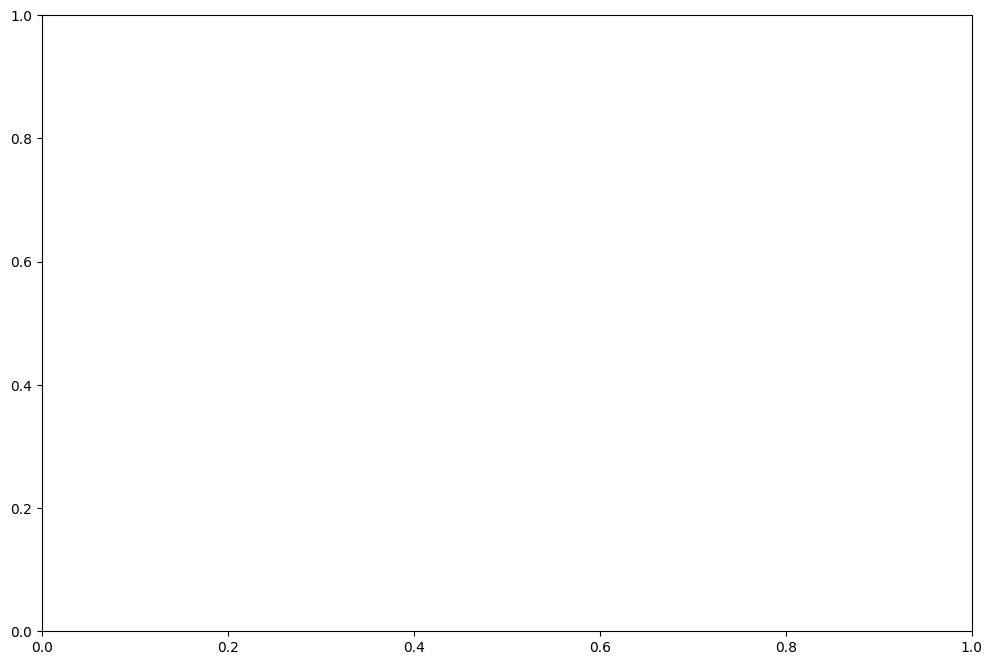

In [21]:
# Tworzenie wykresu
fig, ax1 = plt.subplots(figsize=(12, 8))

for province in provinces:
    
    ax1.bar(province, df_area_solar_wind[province]['energy_production_by_year_mwh'].sum() * 1e-6) #twh
    
plt.xticks(rotation=90)  # Ułatwia czytanie nazw miesięcy
plt.grid(True)
plt.plot(data_combined['Province'],data_combined['energy_consumption_2022'], color = 'red')

plt.title('Wykres przedstawiający możliwości produkcyjne prądu dla każdego województwa w najgorszymi miesiącu pod względem możliwości wytwórczych')
plt.show()    

In [22]:
df_area_solar_wind['podlaskie']

NameError: name 'df_area_solar_wind' is not defined

In [23]:
comb_all_area_solar_wind['december'].sum()*1e-6

NameError: name 'comb_all_area_solar_wind' is not defined

In [24]:
for i in comb_all_area_solar_wind:
    print(i) 

NameError: name 'comb_all_area_solar_wind' is not defined

In [25]:
df = comb_all_area_solar_wind

# # Grupa na podstawie 'id' i sprawdzenie, czy w 'province' lub 'type' są różne wartości
# df_grouped = df.groupby('id').filter(lambda x: x['province'].nunique() > 1 or x['type'].nunique() > 1)
# 
# # Teraz usuniemy duplikaty 'id', zachowując tylko pierwsze wystąpienie
# df_unique = df_grouped.drop_duplicates(subset=[['id','province','type']])

NameError: name 'comb_all_area_solar_wind' is not defined

In [26]:
df_unique = df.drop_duplicates(subset=['id', 'province', 'type'],keep='first')

NameError: name 'df' is not defined

In [27]:
df_unique

NameError: name 'df_unique' is not defined

In [28]:
duplicated_rows = comb_all_area_solar_wind.duplicated(subset=['id', 'province', 'type'])

# Wybranie tylko tych wierszy, które są duplikatami
df_duplicates = comb_all_area_solar_wind[duplicated_rows]
df_duplicates

NameError: name 'comb_all_area_solar_wind' is not defined

In [29]:
df_grouped = df.groupby('province')
df_grouped

NameError: name 'df' is not defined

In [30]:
df_area_solar_wind['pomorskie']

NameError: name 'df_area_solar_wind' is not defined

In [31]:
solar_radiation_photovoltaic_area_by_each_province['dolnoslaskie'][solar_radiation_photovoltaic_area_by_each_province['dolnoslaskie']['id']==4029]

NameError: name 'solar_radiation_photovoltaic_area_by_each_province' is not defined

In [32]:
a = 0
b = 0
for province in provinces:
    a +=solar_radiation_photovoltaic_area_by_each_province[province].shape[0]
    b += wind_energy_production_by_each_province[province].shape[0]
    
print(a)
print(b)

NameError: name 'solar_radiation_photovoltaic_area_by_each_province' is not defined